In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'})

import sys
sys.path.append( '../utils' )
from utils import cap_bank_vals,vdict,plot_tid,start_times

## Still need to address:
- Associate phase-scan index with TID. Should be doable now because we are saving the TID in df_pll.
And we can associate with the timestamp
- Infer best phase setting from widest eye from output eTx.
- Read eTx delay settings from the log (for chip 9?)
```
10-02-22 17:03:54 DEBUG  P-side delay setting: {0: 165, 1: 405, 2: 423, 3: 169, 4: 228, 5: 198, 6: 247, 7: 218, 8: 250, 9: 391, 10: 205, 11: 195, 12: 179}, Eye width: {0: 136, 1: 152, 2: 144, 3: 152, 4: 144, 5: 144, 6: 144, 7: 144, 8: 13\
6, 9: 152, 10: 144, 11: 144, 12: 144}
```
- We can't load the df_scans dataframes since when saved to csv the phase scan arrays lose their array properties and is a mess. For the moment, chose to re-run the parse_scans function which takes a while. So is not optimal.

In [2]:
# Load dataframes
def read_csv(path,cols=[]):
    # Read types first line of csv
    dtypes = pd.read_csv(path, nrows=1).iloc[0].to_dict()
    # columns that need to be parsed as str before dates
    parse_dates = []
    for c in cols:
        dtypes[c] = 'str'
        parse_dates.append(c)
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, skiprows=[1], parse_dates=parse_dates)

df_irr = {}
df_i2c = {}
df_pll = {}
df_scans = {}
for asic in ['9','10']:
    df_irr[asic] = read_csv(f'../data/irr_{asic}.csv',['time'])
    df_i2c[asic] = read_csv(f'../data/i2c_{asic}.csv')
    df_pll[asic] = read_csv(f'../data/pll_{asic}.csv',['time'])
    # df_scans[asic] = read_csv(f'../data/scans_{asic}.csv',['time'])


In [3]:
# problem! the df scans datatypes are all wrong.. 
# need to figure out how to fix this when saving them
# df_scans['9'].eRxScan_1_20.values

In [4]:
# for now use the scans directly
from parse import parse_scans
for asic in ['9','10']:
    df_scans[asic] = parse_scans(asic,['1_20','1_08','1_32'])

In [5]:
print('SCANS ',df_scans['10'].columns)
print('PLL ',df_pll['10'].columns)
print('I2C ',df_i2c['10'].columns)
print('IRR ',df_irr['10'].columns)

SCANS  Index(['time', 'timestamp', 'TID', 'capBank_val', 'phases_trackMode0_1_20',
       'phases_trackMode1_1_20', 'eRxScan_1_20', 'eRxBest_1_20',
       'eRxMaxWidth_1_20', 'eRx2ndMaxWidth_1_20', 'eTxScan_1_20',
       'eTxBest_1_20', 'eTxMaxWidth_1_20', 'eTx2ndMaxWidth_1_20',
       'phases_trackMode0_1_08', 'phases_trackMode1_1_08', 'eRxScan_1_08',
       'eRxBest_1_08', 'eRxMaxWidth_1_08', 'eRx2ndMaxWidth_1_08',
       'eTxScan_1_08', 'eTxBest_1_08', 'eTxMaxWidth_1_08',
       'eTx2ndMaxWidth_1_08', 'phases_trackMode0_1_32',
       'phases_trackMode1_1_32', 'eRxScan_1_32', 'eRxBest_1_32',
       'eRxMaxWidth_1_32', 'eRx2ndMaxWidth_1_32', 'eTxScan_1_32',
       'eTxBest_1_32', 'eTxMaxWidth_1_32', 'eTx2ndMaxWidth_1_32'],
      dtype='object')
PLL  Index(['voltage', 'timestamp', 'cb_settings', 'cb_pusm', 'ngood', 'maxgood',
       'mingood', 'maxgood_index', 'mingood_index', 'third', 'third_index',
       'used', 'used_index', 'used_phases', 'time', 'TID'],
      dtype='object')
I2C 

The following is a demonstration on how to get the possible phases from the dataframes.
The best way is to merge the dataframes and that is shown below.

In [6]:
timestamp = '28Sep_202736'
vstr = '1_20'
voltage = vdict[vstr]
print(voltage)
pll_skim = df_pll['10'].loc[(df_pll['10'].timestamp == timestamp) & (df_pll['10'].voltage == voltage)]
capbank = pll_skim.used.values[0]
# print(pll_skim.cb_settings)

used_phases = np.array([int(x.strip("'")) for x in pll_skim.used_phases.values[0].strip('[').strip(']').replace("''","").split(' ')])
scans_skim = df_scans['10'].loc[(df_scans['10'].timestamp == timestamp) & (df_scans['10'].capBank_val == capbank)]
print('Used phases ',used_phases)
print('Phases trackMode0 ',scans_skim[f'phases_trackMode0_{vstr}'].values[0])
print('Phases trackMode1 ',scans_skim[f'phases_trackMode1_{vstr}'].values[0])

scans_skim

1.2
Used phases  [7 6 7 7 7 8 8 8 7 7 7 7]
Phases trackMode0  [7 6 7 7 7 8 8 8 7 7 7 7]
Phases trackMode1  [5 5 5 5 5 7 6 7 5 7 5 5]


,time,timestamp,TID,capBank_val,phases_trackMode0_1_20,phases_trackMode1_1_20,eRxScan_1_20,eRxBest_1_20,eRxMaxWidth_1_20,eRx2ndMaxWidth_1_20,...,phases_trackMode0_1_32,phases_trackMode1_1_32,eRxScan_1_32,eRxBest_1_32,eRxMaxWidth_1_32,eRx2ndMaxWidth_1_32,eTxScan_1_32,eTxBest_1_32,eTxMaxWidth_1_32,eTx2ndMaxWidth_1_32
2070,2022-09-28 20:27:36,28Sep_202736,295.9421,29,"[7, 6, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7]","[5, 5, 5, 5, 5, 7, 6, 7, 5, 7, 5, 5]","[[1, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [255,...","[7, 6, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7]","[3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4]","[2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2]",...,"[3, 10, 11, 3, 3, 12, 4, 11, 11, 3, 11, 11]","[11, 9, 11, 4, 11, 5, 5, 5, 11, 4, 4, 11]","[[255, 10, 255, 255, 255, 255, 255, 255, 255, ...","[3, 10, 11, 3, 3, 12, 4, 11, 11, 3, 11, 11]","[3, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 3]","[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[[2634, 24, 0, 2412, 0, 0, 0, 0, 0, 121, 0, 0,...","[14, 14, 17, 13, 2, 18, 2, 19, 2, 15, 2, 17, 16]","[16, 16, 16, 16, 19, 16, 17, 17, 17, 16, 16, 16]","[15, 16, 15, 16, 16, 15, 16, 16, 15, 15, 16, 15]"


Plot Temperature and Current

In [7]:
def plot_conditions(asic,voltages,tid=False):
    col,axtitle = plot_tid(tid)
    
    x = df_irr[asic]
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for v in voltages:
        y = x.loc[(x.voltage==v) & (x.time > start_times[asic])]
        ax.scatter(y[col],y.temp,label=f'{v} V')
    ax.set_xlabel(axtitle)
    ax.set_ylabel('Temperature (C)');
    ax.set_title(f'Conditions, ASIC {asic}')
    ax.legend()
    if not tid:
        fig.autofmt_xdate()
        
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for v in voltages:
        y = x.loc[x.voltage==v]
        ax.plot(y[col],y.current,label=f'{v} V')
    ax.set_xlabel(axtitle)
    ax.set_ylabel('Current (mA)');
    ax.legend()
    if not tid:
        fig.autofmt_xdate()

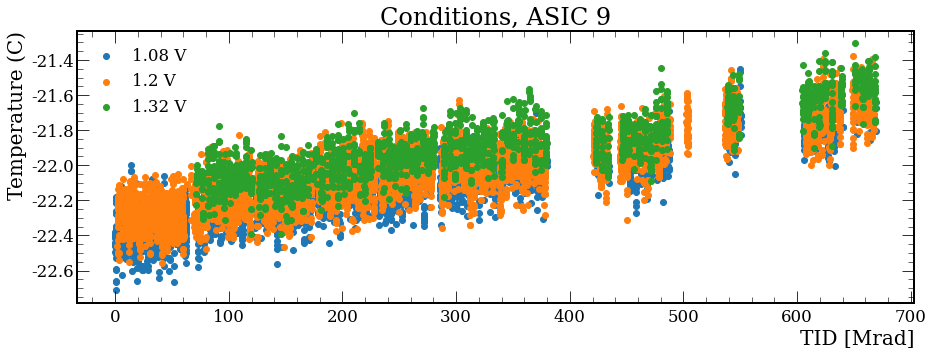

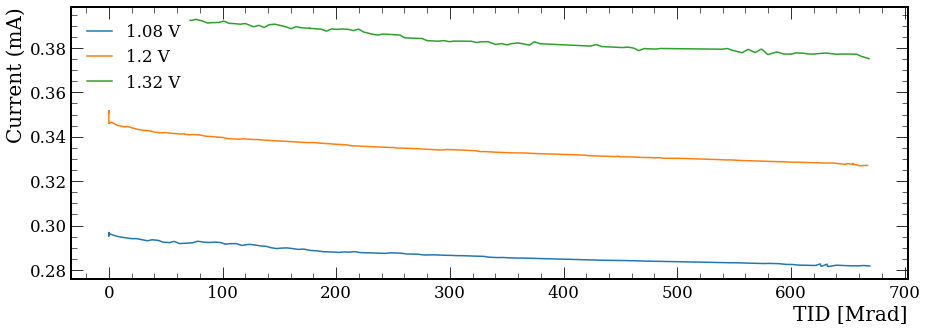

In [8]:
plot_conditions('9',[1.08,1.2,1.32],True)

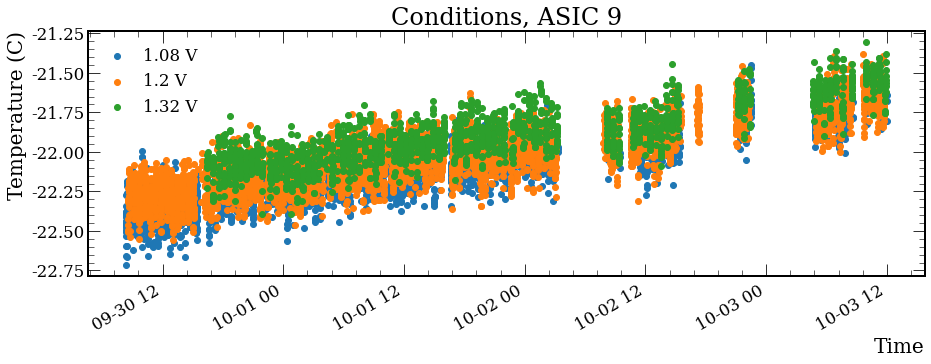

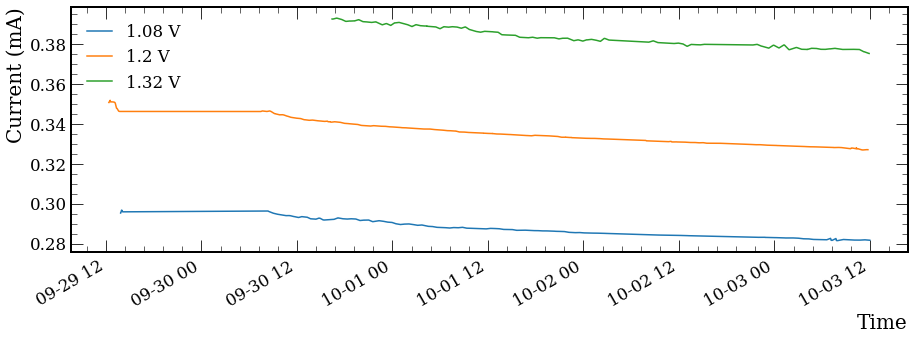

In [9]:
plot_conditions('9',[1.08,1.2,1.32],False)

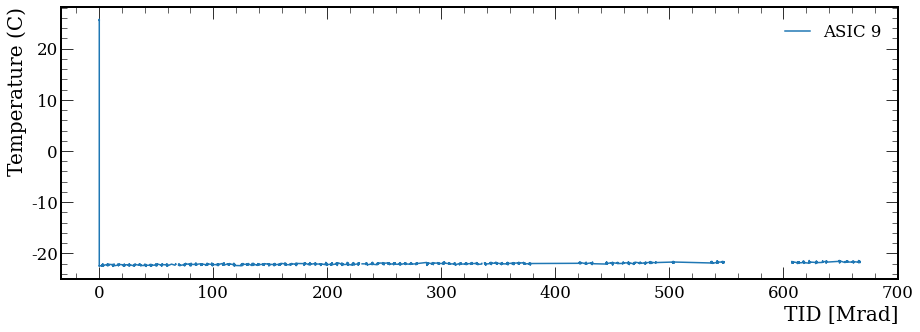

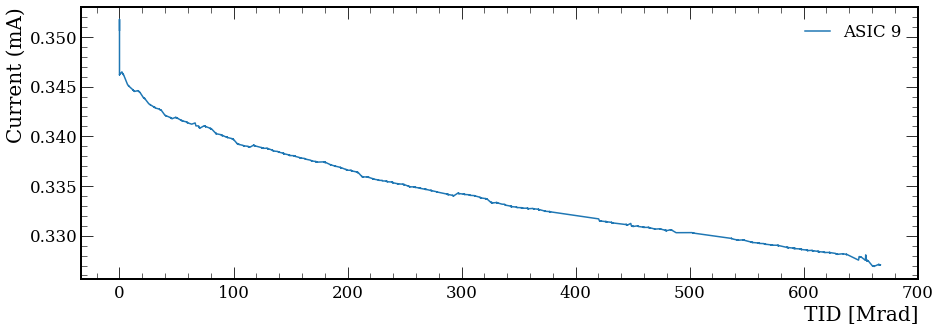

In [10]:
def plot_conditions_asics(asics):
    col,axtitle = plot_tid('True')
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for asic in asics:
        x = df_irr[asic]
        x = x.loc[x.voltage==1.2]
        ax.plot(x[col],x.temp,label=f'ASIC {asic}')
    ax.set_xlabel(axtitle)
    ax.set_ylabel('Temperature (C)');
    ax.legend()

    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for asic in asics:
        x = df_irr[asic]
        x = x.loc[x.voltage==1.2]
        ax.plot(x[col],x.current,label=f'ASIC {asic}')
    ax.set_xlabel(axtitle)
    ax.set_ylabel('Current (mA)');
    ax.legend()

plot_conditions_asics(['9'])

Plot i2c Comparison Errors, for a given voltage

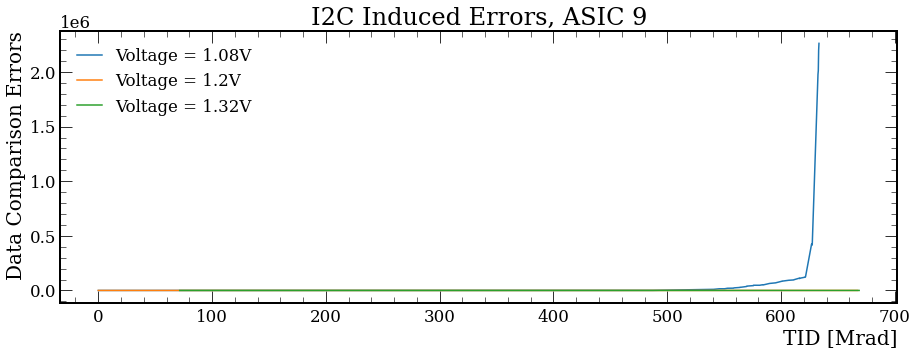

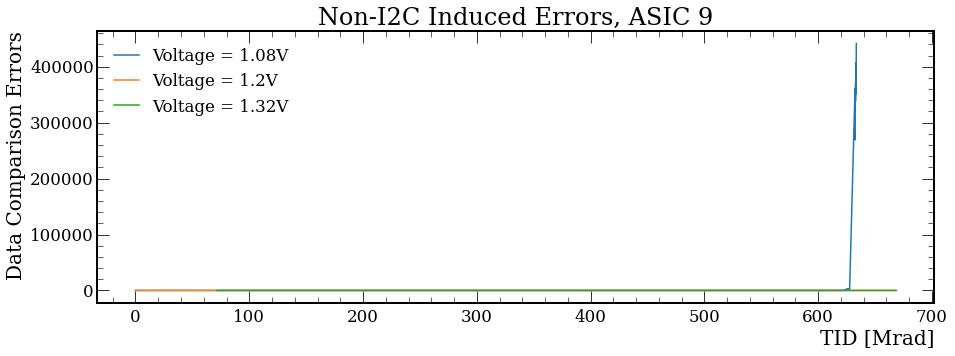

In [11]:
def plot_i2c_errors(asic,tid=True,isi2c=True):
    voltages = {'9':[1.08,1.2,1.32],'10': [1.2]}    
    col,axtitle = plot_tid(tid)
        
    volt = voltages[asic]
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for voltage in volt:
        v = round(voltage,1)
        x = df_irr[asic]
        voltage_round = x.voltage.round(decimals=1)
        sel = (x.errRate<0.9) & (voltage_round == v)
        if isi2c:
            sel = sel & (x.isI2C)
        else:
            sel = sel & ~(x.isI2C)
        d = x.loc[sel]
        # ax.plot(d[col],d.errRate,label=f'Voltage = {voltage}V')
        ax.plot(d[col],d.nErr,label=f'Voltage = {voltage}V')
    ax.set_xlabel(axtitle)
    ax.set_ylabel('Data Comparison Errors')
    if isi2c:
        ax.set_title(f'I2C Induced Errors, ASIC {asic}')
    else:
        ax.set_title(f'Non-I2C Induced Errors, ASIC {asic}')
    ax.legend()
    #ax.set_ylim(-1,200);
    if not tid:
        fig.autofmt_xdate()
    
for asic in ['9']:
    # plot i2c errors
    plot_i2c_errors(asic,True,True)
    # plot non-i2c errors
    plot_i2c_errors(asic,True,False)

Plot PLL CapBank Choice or Used as a function of time/TID

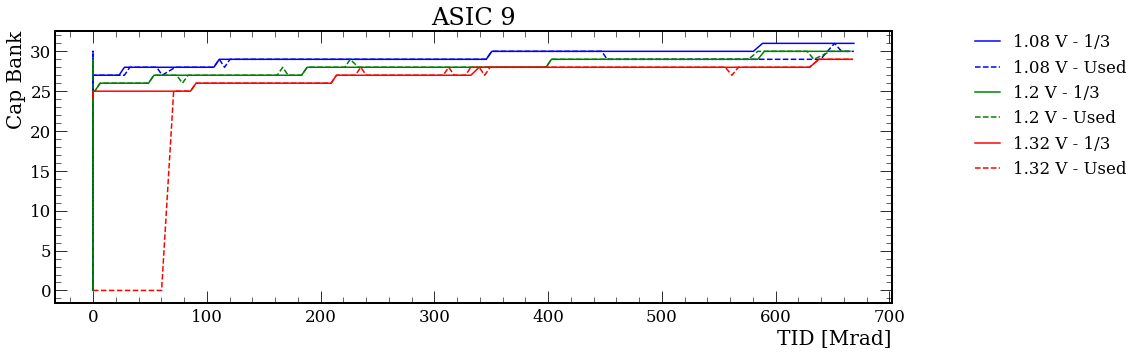

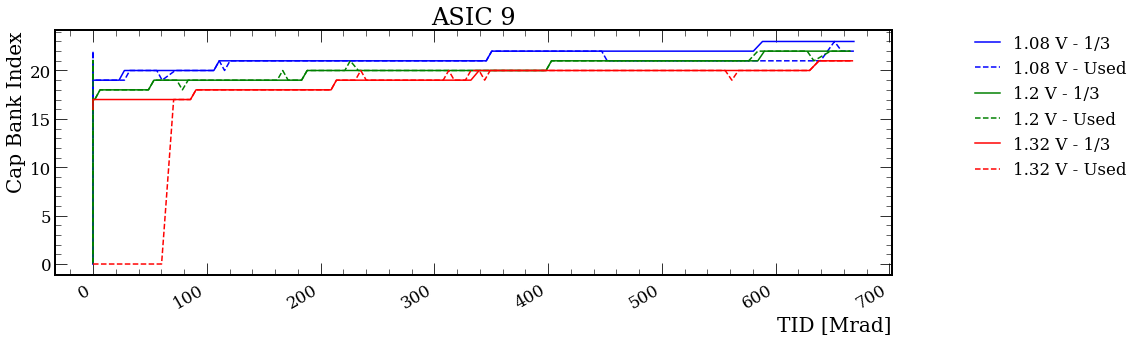

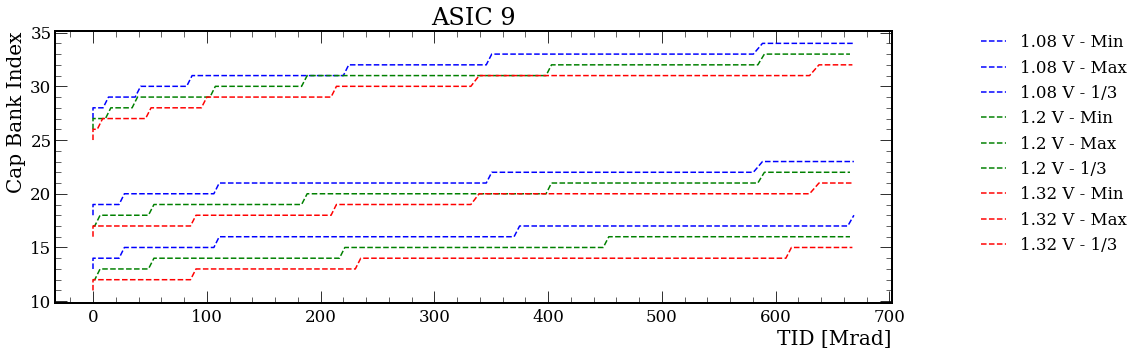

In [12]:
vcolors = {
    1.08: 'blue',
    1.2: 'green',
    1.32: 'red',
}
def plot_pllchoice_time(asic,tid=True):
    col,axtitle = plot_tid(tid)
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for v in [1.08,1.2,1.32]:
        x = df_pll[asic]
        x = x[x.voltage==v]
        ax.plot(x[col],x['third'],color=vcolors[v],label=f'{v} V - 1/3')
        ax.plot(x[col],x['used'],color=vcolors[v],label=f'{v} V - Used',linestyle='dashed')
    ax.set_ylabel('Cap Bank')
    #ax.set_ylim(17,25)
    ax.set_xlabel(axtitle)
    ax.legend(bbox_to_anchor=(1.3, 1.05))
    ax.set_title(f'ASIC {asic}')
    if not tid:
        fig.autofmt_xdate()
        
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for v in [1.08,1.2,1.32]:
        x = df_pll[asic]
        x = x[x.voltage==v]
        ax.plot(x[col],x['third_index'],color=vcolors[v],label=f'{v} V - 1/3')
        ax.plot(x[col],x['used_index'],color=vcolors[v],label=f'{v} V - Used',linestyle='dashed')
    ax.set_ylabel('Cap Bank Index')
    #ax.set_ylim(17,25)
    ax.set_xlabel(axtitle)
    ax.legend(bbox_to_anchor=(1.3, 1.05))
    ax.set_title(f'ASIC {asic}')
    fig.autofmt_xdate()
        
    fig,ax=plt.subplots(1,1,figsize=(15,5))
    for v in [1.08,1.2,1.32]:
        x = df_pll[asic]
        x = x[x.voltage==v]
        ax.plot(x[col],x['mingood_index'],linestyle='--',color=vcolors[v],label=f'{v} V - Min')
        ax.plot(x[col],x['maxgood_index'],linestyle='--',color=vcolors[v],label=f'{v} V - Max')
        ax.plot(x[col],x['third_index'],linestyle='--',color=vcolors[v],label=f'{v} V - 1/3')
    ax.set_ylabel('Cap Bank Index')
    ax.set_xlabel(axtitle)
    ax.legend(bbox_to_anchor=(1.3, 1.05))
    ax.set_title(f'ASIC {asic}')
    
for asic in ['9']:
    plot_pllchoice_time(asic)

Plot the phase scan, for the PLL setting that was actually used.

Phases used ch 0 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 7 8 8 8 8 8 8
 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 6 7 7 7 7 7 7 7 7 6 6 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 4 4
 4 4 4 5 4]
Phases trackMode0 ch 0 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 7 8 8 8 8 8 8
 8 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 6 7 7 7 7 7 7 7 7 6 6 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 4 4
 4 4 4 5 4]
Phases trackMode1 ch 0 [7 8 8 8 8 8 8 8 8 8 8 8 8 9 6 7 7 7 7 7 7 7 7 7 7 7 8 7 8 7 8 7 7 7 8 8 7
 8 8 8 8 6 5 6 5 5 6 6 5 5 6 5 6 6 6 6 6 6 6 6 6 7 6 7 6 7 6 7 7 7 7 6 7 6
 6 6 7 6 6 7 7 7 7 9 9 5 5 5 5 5 5 5 5 6 5 5 5 5 6 5 6 5 5 5 6 5 5 6 5 5 5
 5 5 5 5 5]


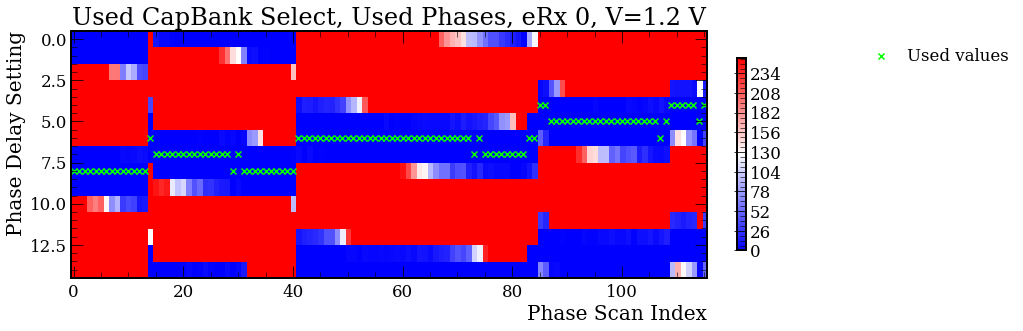

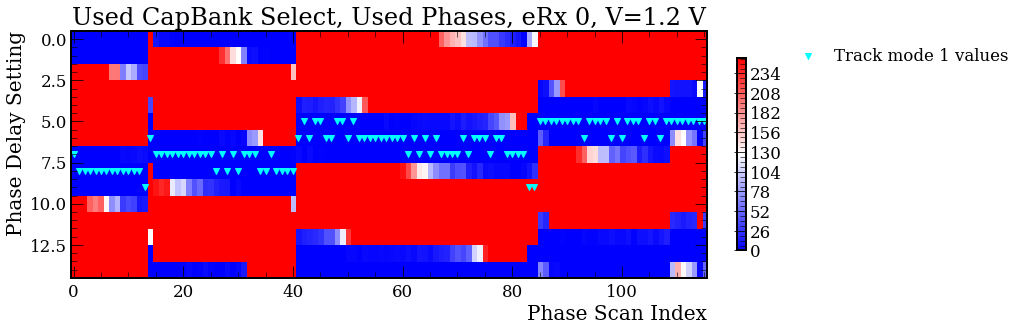

In [13]:
asic = '9'
v_str = '1_20'
v = vdict[v_str]
pll_voltage_sel = (df_pll[asic].voltage == v)
df1 = df_pll[asic].loc[pll_voltage_sel] # 5
df2 = df_scans[asic].loc[df_scans[asic].timestamp.isin(df1.timestamp)]

# this  part is very important to be able to work with both dataframes
df_merge = df1.merge(df2, on='timestamp', how='right')
df_merge = df_merge.loc[df_merge.capBank_val == df_merge.used]

# phase scans
scan = 'eRx'
scanname = f'{scan}Scan_{v_str}'
scans = np.array(list(df_merge[scanname].values))

# used capbank
used_capbank = df_merge.used.values
# used phases - should be the same as trackmode0 - most times? this weird conversion...
used_phases = []
for y in df_merge.used_phases.values:
    try:
        used_phases.append(np.array([int(x.strip("''")) for x in y.strip('[').strip(']').replace("''","").split(' ')]))
    except:
        used_phases.append(np.fromstring(y.strip('[').strip(']'),dtype=int,sep=' '))
used_phases = np.array(used_phases)

"""
print('Timestamps ',df_merge.timestamp)
print('Used CapBank values ',used_capbank)
print('Used Phases ',used_phases)
print('PUsed Phases - length - ',len(used_phases))
print('Used capbank ',used_capbank)
print('Phases trackMode0 - length ',len(df_merge[f'phases_trackMode0_{v_str}'].values))
"""

# plot the phase scan for the PLL setting that was actually used
cmap = mpl.colormaps['bwr']
if 'eRx' in scan: 
    #bounds=[0,50,100,255]
    bounds = np.arange(255)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# for eRx 0
channel = 0

# this array is also weird..
phase_scan = scans[:,:,channel].T
phases0_ch = np.array([x[channel] for x in df_merge[f'phases_trackMode0_{v_str}'].values])
phases1_ch = np.array([x[channel] for x in df_merge[f'phases_trackMode1_{v_str}'].values])

print(f'Phases used ch {channel}',used_phases[:,0])
print(f'Phases trackMode0 ch {channel}',phases0_ch)
print(f'Phases trackMode1 ch {channel}',phases1_ch)

fig,ax=plt.subplots(1,1,figsize=(15,5))
im=ax.imshow(phase_scan,cmap=cmap,norm=norm)
fig.colorbar(im,fraction=0.013, pad=0.04,ax=ax)
ax.set_aspect(3)
ax.set_xlabel('Phase Scan Index')
ax.set_ylabel('Phase Delay Setting')
ax.set_title(f'Used CapBank Select, Used Phases, {scan} {channel}, V={v} V')
ax.scatter(np.arange(phase_scan.shape[1]),used_phases[:,0],marker='x',color='lime',label='Used values')
ax.legend(bbox_to_anchor=(1.5, 1))
fig.tight_layout()


fig,ax=plt.subplots(1,1,figsize=(15,5))
im=ax.imshow(phase_scan,cmap=cmap,norm=norm)
fig.colorbar(im,fraction=0.013, pad=0.04,ax=ax)
ax.set_aspect(3)
ax.set_xlabel('Phase Scan Index')
ax.set_ylabel('Phase Delay Setting')
ax.set_title(f'Used CapBank Select, Used Phases, {scan} {channel}, V={v} V')
ax.scatter(np.arange(phase_scan.shape[1]),phases1_ch,marker='v',color='cyan',label='Track mode 1 values')
ax.legend(bbox_to_anchor=(1.5, 1))
fig.tight_layout()




#df_merge

Plot header mis-match errors

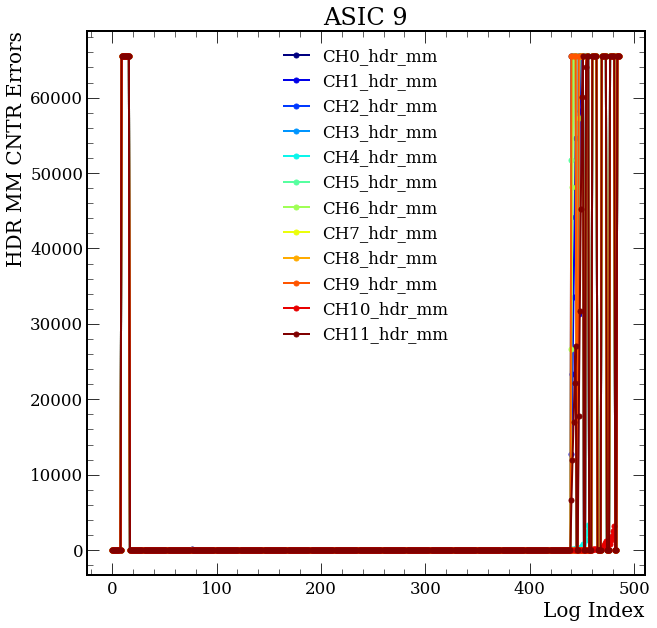

In [14]:
asic = '9'
ax = df_i2c[asic].plot(lw=2,colormap='jet',marker='.',markersize=10,title='Video streaming dropout by category')
ax.set_xlabel('Log Index')
ax.set_ylabel('HDR MM CNTR Errors')
ax.set_title(f'ASIC {asic}')
ax.legend()
fig.tight_layout()

Plot width of phase scans as a function of TID

In [15]:
def plot_width_tid(asic,scan,voltage,aspect=2,maxwidth='MaxWidth'):
    x = df_scans[asic]
    tid = np.array(x.loc[x.capBank_val == 31][f'TID'].values)
    width = []
    for val in cap_bank_vals:
        width.append(np.array(list(x.loc[x.capBank_val == val][f'{scan}{maxwidth}_{voltage}'].values)).mean(axis=1))
    width = np.array(width)

    fig,ax=plt.subplots(figsize=(12,9))
    cmap = mpl.colormaps['viridis']
    bounds=[0,1,2,3,4]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # attempt to show TID instead of phase scan index
    #im = ax.imshow(width,cmap=cmap,norm=norm,extent=(0,tid[-1],len(cap_bank_vals),0))
    
    im = ax.imshow(width,cmap=cmap,norm=norm)
    
    fig.subplots_adjust(right=0.85)
    fig.colorbar(im,fraction=0.019, pad=0.04)
    ax.set_aspect(aspect)
    #ax.scatter(tid,width.argmax(axis=0),marker='x',color='w',label='PLL CapBank index with maximum width')
    ax.scatter(np.arange(width.shape[1]),width.argmax(axis=0),marker='x',color='w',label='PLL CapBank index with maximum width')
    #ax.set_xticks([tid[20],tid[40],tid[60],tid[80],tid[100]])
    ax.legend(labelcolor='w')
    ax.set_title(f'{maxwidth} of eRx good phases at {vdict[voltage]} V')
    ax.set_ylabel('PLL CapBank')
    ax.set_xlabel('Phase Scan Index')
    #ax.set_xlabel('TID [Mrad]')
    fig.tight_layout()

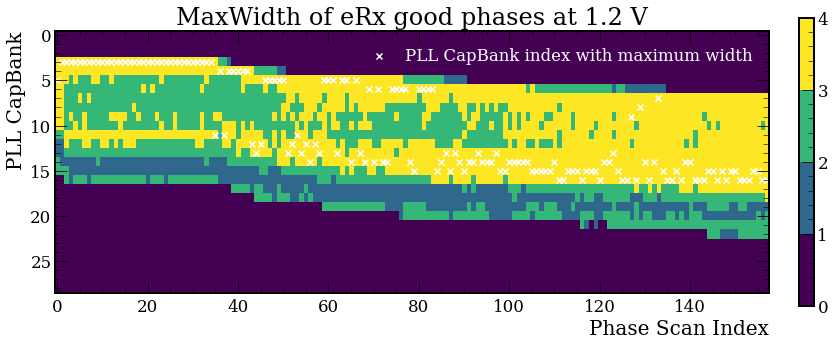

In [16]:
plot_width_tid('9','eRx','1_20',aspect=2,maxwidth='MaxWidth')

Plot Delay Scans as a function of TID for a given eRx/eTx

In [17]:
def plot_phase_scans_tid(asic,scan,voltage,channel,aspect=2,pll_values = [25,26,27,28,29,30,31,56,57,58,59,60,61,62,63]):
    cmap = mpl.colormaps['bwr']
    if scan=='eRx': 
        #bounds=[0,50,100,255]
        bounds = np.arange(255)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
    x = df_scans[asic]
    fig,ax=plt.subplots(figsize=(12,5*len(pll_values)),ncols=1,nrows=len(pll_values))
    for i,val in enumerate(pll_values):
        try:
            ax_i = ax[i]
        except:
            ax_i = ax
        
        d=np.array(list(x.loc[x.capBank_val == val][f'{scan}Scan_{voltage}'].values))
        #print(x)
        
        if scan=='eRx':
            im=ax_i.imshow(d[:,:,channel].T,cmap=cmap,norm=norm)
        else:
            im=ax_i.imshow(d[:,:,channel].T,cmap=cmap)
        # the following was an attempt to modify the axis to TID..
        #im=ax[i].imshow(x[:,:,channel].T,cmap=cmap,norm=norm,aspect=1.5,extent=(0,tid[-1],x[:,:,channel].shape[1],0))
        fig.colorbar(im,fraction=0.013, pad=0.04,ax=ax_i)
        ax_i.set_aspect(aspect)
        ax_i.set_xlabel('Phase Scan Index')
        #ax_i.set_xlabel('TID')
        ax_i.set_ylabel('Phase Delay Setting')
        ax_i.set_title(f'CapBank Select {val},{scan} {channel}, V={vdict[voltage]} V')
    fig.tight_layout()

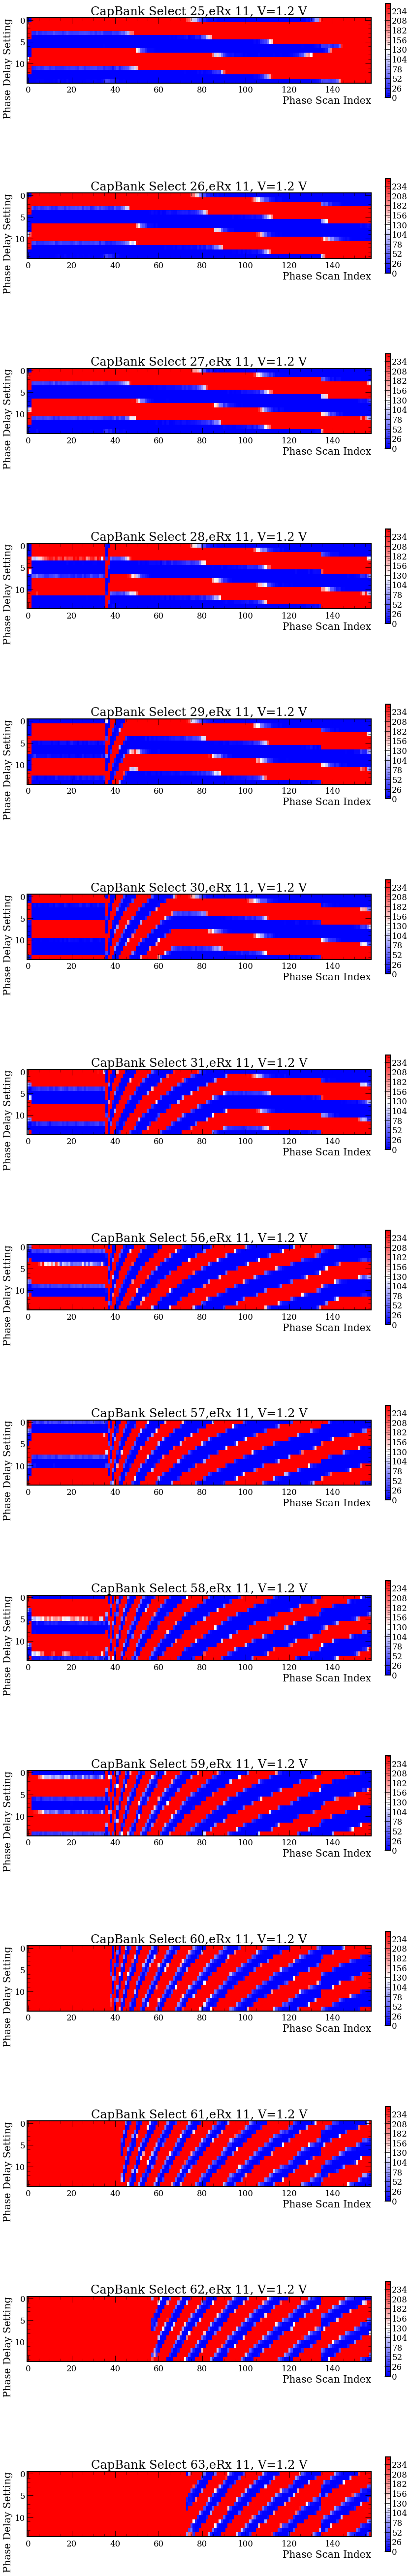

In [18]:
plot_phase_scans_tid('9','eRx','1_20',11,aspect=2)

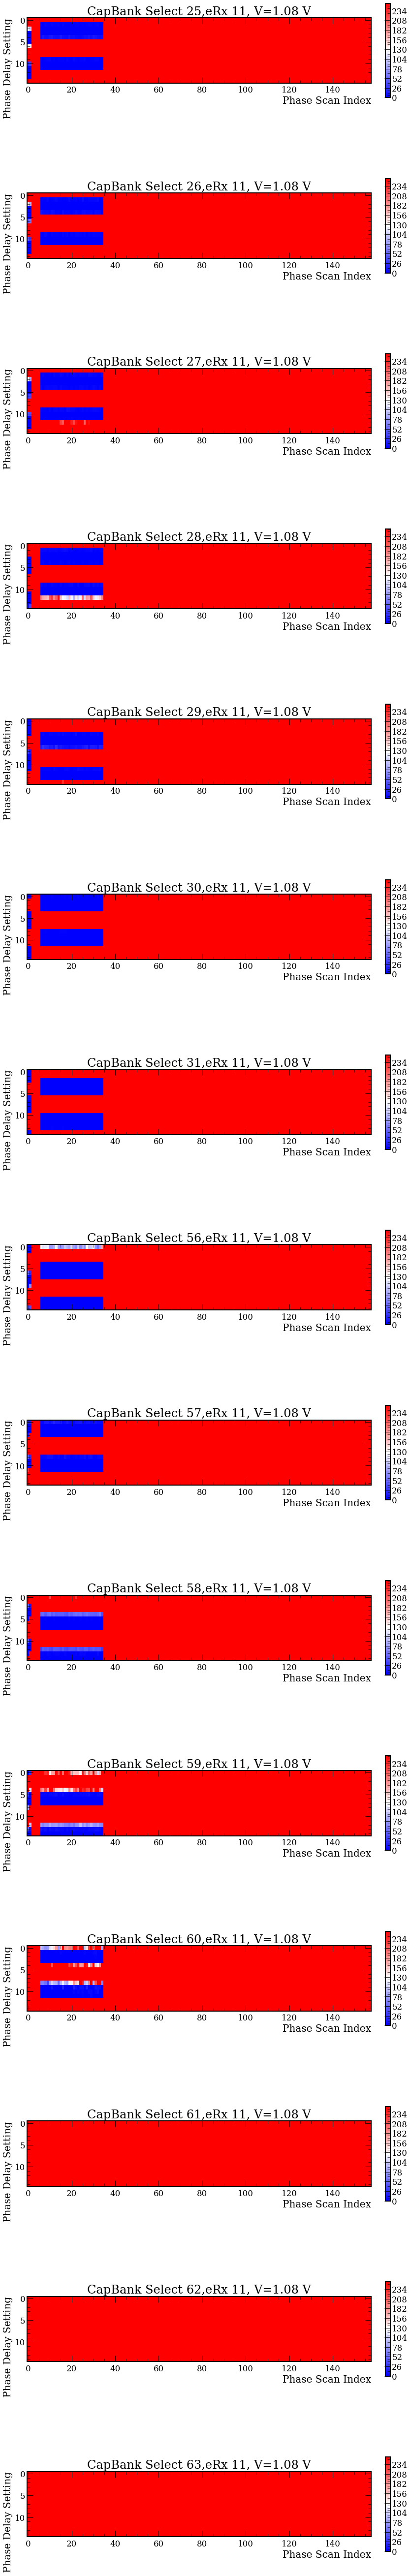

In [19]:
plot_phase_scans_tid('9','eRx','1_08',11,aspect=2)

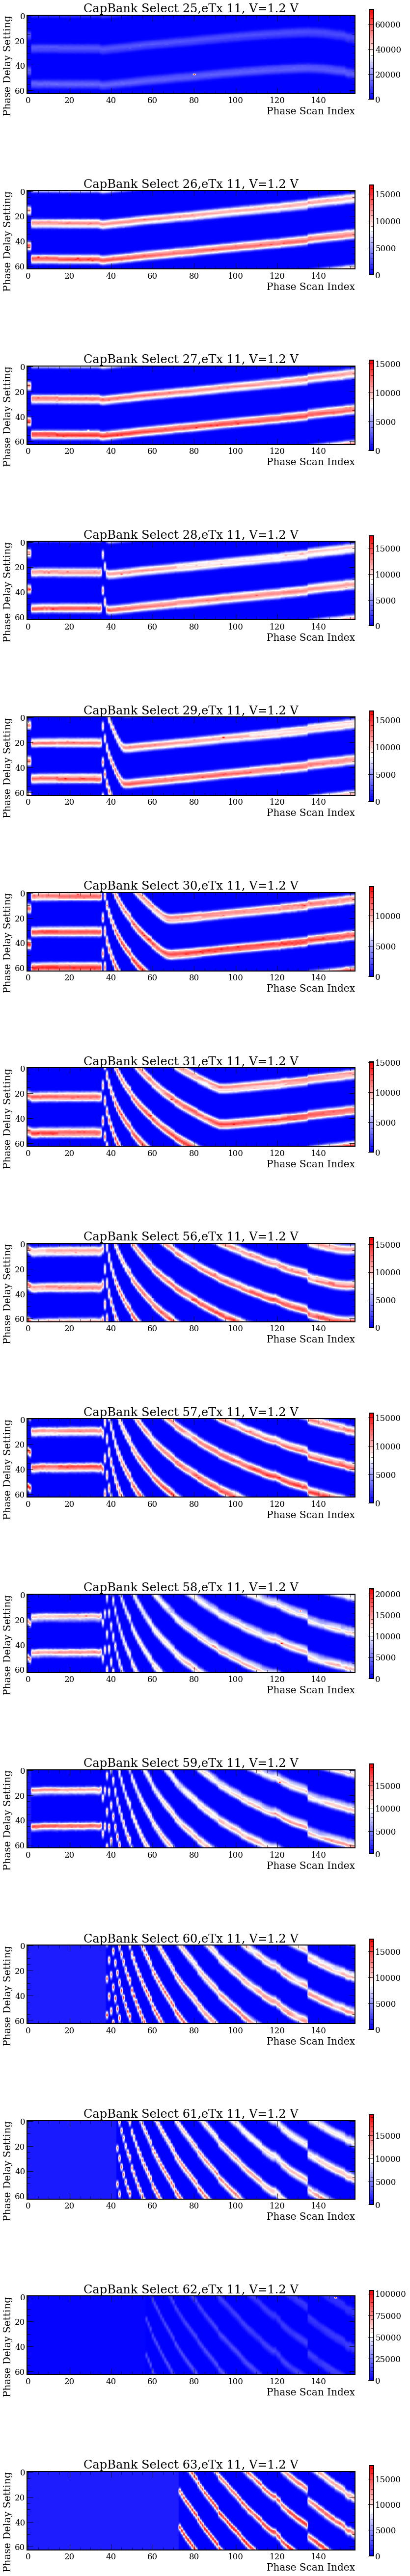

In [20]:
plot_phase_scans_tid('9','eTx','1_20',11,aspect=.6)

We can try to select only given PLL values too

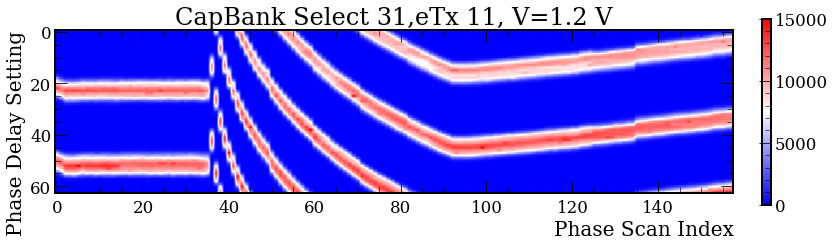

In [21]:
plot_phase_scans_tid('9','eTx','1_20',11,aspect=.6,pll_values=[31])

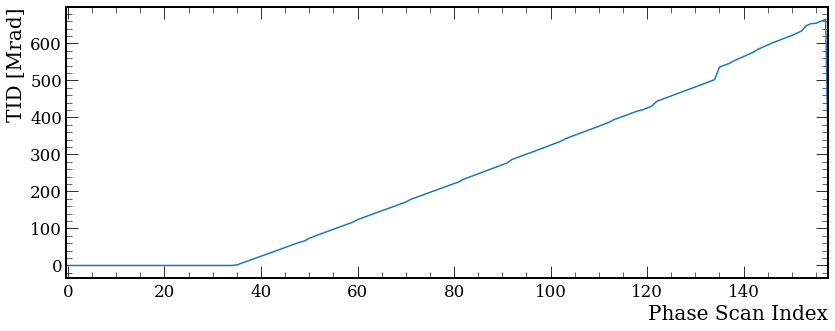

In [22]:
# Plot TID as a function of phase scan index
asic = '9'
x = df_scans[asic]
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.plot(np.arange(len(x)),x.TID)
x=np.array(list(x.loc[x.capBank_val == 31][f'eRxScan_1_20'].values))
ax.set_xlim(-0.5,x.shape[0]-0.5);
ax.set_ylabel('TID [Mrad]')
ax.set_xlabel('Phase Scan Index')
fig.tight_layout()

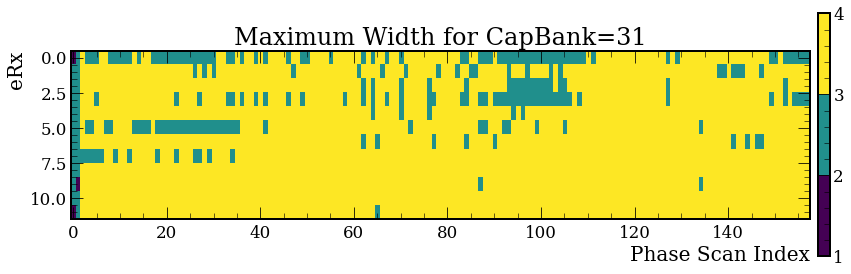

In [23]:
voltage = '1_20'
scan = 'eRx'
capBank = 31
asic = '9'
x = df_scans[asic]
x=np.array(list(x.loc[x.capBank_val == capBank][f'{scan}MaxWidth_{voltage}'].values))
#print(x[0])

fig,ax=plt.subplots(figsize=(12,9))
cmap = mpl.colormaps['viridis']
#bounds= [0,0.5,1,1.5,2,2.5,3,3.5,4]
bounds = [1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im=plt.imshow(x.T,cmap=cmap,norm=norm)
fig.colorbar(im,fraction=0.016, pad=0.01,ax=ax)
ax.set_aspect(3)
ax.set_xlabel('Phase Scan Index')
ax.set_ylabel(f'{scan}')
ax.set_title(f'Maximum Width for CapBank={capBank}')
fig.tight_layout()